In [1]:
#PACT Daily Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
#from datetime import timedelta
import os
import calendar
from pvlib.location import Location
from pptx import Presentation
from pptx.util import Inches
import json
from multiprocess import Pool
from tqdm.notebook import tqdm

# Box dependencies
from box_sdk_gen import (
    BoxClient, CCGConfig, BoxCCGAuth,
    UploadFileAttributes, UploadFileAttributesParentField,
    UploadFileVersionAttributes,
)
from box_sdk_gen.networking import NetworkSession
PACT_ROOT_FOLDER_ID = '156583351713' #PACT_Data
username = 'jsstein@sandia.gov'
flat_file_path = f'/Users/jsstein/bin/Box Sync/PACT - Data'

#AWS S3 
# "dev" matches the name in ~/.aws/config
os.environ['AWS_PROFILE'] = 'dev'
os.environ['AWS_DEFAULT_PROFILE'] = 'dev'
os.environ['HTTP_PROXY'] = 'http://proxy.sandia.gov:80'
os.environ['HTTPS_PROXY'] = 'http://proxy.sandia.gov:80'
os.environ['REQUESTS_CA_BUNDLE'] = '/Users/jsstein/Documents/SNL_Root_CA.crt'
os.environ['AWS_CA_BUNDLE'] = '/Users/jsstein/Documents/SNL_Root_CA.crt'
from tqdm import tqdm
import boto3
s3 = boto3.resource('s3')
bucket = s3.Bucket('pvivdb-transfer')

# Load functions
%run NEW_PACT_Functions.ipynb

# This module is still in active development, so we load it straight from the
# repository, skipping the installation step
import importlib
import sys
sys.path.insert(0, f'/Users/jsstein/bin/pact_analysis')
sys.path.insert(0, f'/Users/jsstein/bin/pact_plots')
import pact_plots
importlib.reload(pact_plots)
import pact_analysis
importlib.reload(pact_analysis)
pass

import urllib3
urllib3.disable_warnings()

censored_days_path = '/Users/jsstein/bin/PACT/Daily_analysis/PACT_SNL_censored_days_SETUP.csv'

#Setup database connection
import pyodbc
import os
from sqlalchemy import create_engine

server = 'DB03SNLNT\PR'  # e.g., 'localhost\SQLEXPRESS' or 'your_server_ip'
database = 'PVGrid'
username = 'PVGridUser'
password = os.getenv('DB_PASSWORD_PRuser')

connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'
engine = create_engine(connection_string)

In [2]:
%%bash
aws sso login --sso-session my-sso

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open, open the following URL:

https://oidc.us-west-2.amazonaws.com/authorize?response_type=code&client_id=16K9IaSsQhDRwjVOYRxYjHVzLXdlc3QtMg&redirect_uri=http%3A%2F%2F127.0.0.1%3A65438%2Foauth%2Fcallback&state=d2d4562f-beeb-46af-87e2-356f0c8d2ddc&code_challenge_method=S256&scopes=sso%3Aaccount%3Aaccess&code_challenge=gkKWU4ChyPMAKlc8HiYoKmW3rsRNrrszNXKOXpmNud0
Successfully logged into Start URL: https://nrel-ace.awsapps.com/start/#


In [2]:
#Read in module setup files and assign varaibles
active_modules, allsamples, allareas, module_types, batches, batches2 = read_pact_modules()



#Loop through active modules and check for Box folder and metadata files
for index, row in active_modules.iterrows():
    pact_id = row['PACT_id']
    print('pact_id: ' + pact_id)
    

    #Check if BOX folder exists
    path = '/Users/jsstein/bin/Box Sync/PACT - Data/'+ pact_id[:6] + '-XX'
    module_metadata_path = path + '/Outdoor_SNL/data/metadata/module-metadata.json'
    site_metadata_path = path + '/Outdoor_SNL/data/metadata/site-metadata.json'
    
    if os.path.isdir(path):
        print("Path exists: " + path)
        # Is pact_id is in module-metadata.json?
        
        if check_for_new_module(pact_id, module_metadata_path):
            print(pact_id + ' is included in module-metadata.json')
        else:
            # Add pact_id to module-metadata.json
            add_module_to_metadata(module_metadata_path, pact_id)
            print('Adding ' + pact_id + ' to module-metadata.json')
        
    else:
        # Do these things if the directory does not exist:
        #    (1) Make directories
        #    (2) Make module_metadata.json
        #    (3) Make site_metadata.json

        # (1) Make directories
        os.mkdir(path)
        os.mkdir(path + '/Outdoor_SNL')
        os.mkdir(path + '/Outdoor_SNL/daily_plots')
        os.mkdir(path + '/Outdoor_SNL/data')
        os.mkdir(path + '/Outdoor_SNL/data/metadata')
        os.mkdir(path + '/Outdoor_SNL/data/point_data')

        # (2) Make module_metadata.json
        make_module_metadata_json(module_metadata_path, pact_id[:6], batches, allareas, module_types)
        
        # (3) Make site_metadata.json
        make_site_metadata_json(site_metadata_path, label = 'SNL', 
                                latitude = 35.05, longitude=-106.54, elevation=1657,
                                surface_tilt = 'null', surface_azimuth='null')

# Read in censored days file and loop through censored days to update metadata files
read_censored_days(censored_days_path)

pact_id: P-0042-04
Path exists: /Users/jsstein/bin/Box Sync/PACT - Data/P-0042-XX
P-0042-04 is included in module-metadata.json
pact_id: P-0122-02
Path exists: /Users/jsstein/bin/Box Sync/PACT - Data/P-0122-XX
P-0122-02 is included in module-metadata.json
pact_id: P-0122-04
Path exists: /Users/jsstein/bin/Box Sync/PACT - Data/P-0122-XX
P-0122-04 is included in module-metadata.json
pact_id: P-0123-04
Path exists: /Users/jsstein/bin/Box Sync/PACT - Data/P-0123-XX
P-0123-04 is included in module-metadata.json
pact_id: P-0134-01
Path exists: /Users/jsstein/bin/Box Sync/PACT - Data/P-0134-XX
P-0134-01 is included in module-metadata.json
pact_id: P-0137-01
Path exists: /Users/jsstein/bin/Box Sync/PACT - Data/P-0137-XX
P-0137-01 is included in module-metadata.json
pact_id: P-0137-03
Path exists: /Users/jsstein/bin/Box Sync/PACT - Data/P-0137-XX
P-0137-03 is included in module-metadata.json
pact_id: P-0137-04
Path exists: /Users/jsstein/bin/Box Sync/PACT - Data/P-0137-XX
P-0137-04 is included 

In [3]:
active_modules

,Start_date,End_date,PACT_id,PSEL_id,Area,Active,Type,Notes
20,11/21/23,NaN,P-0042-04,5097,0.002500,Y,MHP,NaN
67,8/5/25,NaN,P-0122-02,5424,0.065780,Y,MHP,NaN
69,8/5/25,NaN,P-0122-04,5426,0.065780,Y,MHP,NaN
73,8/5/25,NaN,P-0123-04,5430,0.065780,Y,MHP,NaN
74,10/20/25,NaN,P-0134-01,5431,0.065520,Y,MHP,NaN
78,10/27/25,NaN,P-0137-01,5436,0.013125,Y,MHP,NaN
79,10/27/25,NaN,P-0137-03,5438,0.013125,Y,MHP,NaN
80,10/27/25,NaN,P-0137-04,5439,0.013125,Y,MHP,NaN
81,10/27/25,NaN,P-0137-05,5440,0.013125,Y,MHP,NaN
82,10/27/25,NaN,P-0138-01,5435,0.013125,Y,MHP,NaN


In [4]:
#All Modules
#Workflow for reading from database
yearmonth = '2026-02'
start_date = pd.Timestamp(yearmonth + '-01 00:00:00')
if yearmonth[5:6]=='0':
    month = yearmonth[6:]
else:
    month = yearmonth[5:]
lastday = calendar.monthrange(int(yearmonth[0:3]), int(month))[1]
end_date = yearmonth + '-' + f"{lastday:02}" + ' 23:59:59'
date_range = pd.date_range(start=start_date, end=end_date)
print(f"start_date={start_date}, end_date={end_date}")

#First Step is to query all data from database for the month
tablename = 'dbo.PACT_MPPTData'
sql = f"SELECT * FROM {tablename} WHERE TmStamp BETWEEN '{start_date}' AND '{end_date}' ORDER BY TmStamp ASC"
df = pd.read_sql(sql, engine, index_col="TmStamp")
df.index = df.index.tz_localize('MST')
df.drop(columns=['PACTMPPTDataID', 'Power', 'Filename'], inplace=True)
df = df.rename(columns={'Voltage': 'vmp', 'Current': 'imp', 'Temperature':'temperature_module'})
df = df.rename_axis('date_time')

# Main Active Module Loop
for index, row in active_modules.iterrows():
    pact_id = row['PACT_id']

   #Process modules  #Needs to be tested- function caused errors
   #process_module(df, pact_id, start_date, end_date)

    #Filter out modules other than current pact_id
    dfmod = df.loc[df['ModuleID']==pact_id,:]
    if dfmod.empty:
        print(pact_id + ': No data')
        break
    else:
        print(pact_id + ': Latest MPPT TmStamp = ' + dfmod.index[-1].strftime('%Y-%m-%d %H:%M') + ' Testpad = ' + str(dfmod['TestPad'].iloc[-1]) )
    # TestPad 4: East Pact Tracker (PACTTracker1)
    if dfmod['TestPad'].iloc[-1] == 4: 
        tablename = 'dbo.PACT_MET_PACTTracker1'
        sql = f"SELECT TmStamp, E_Tracker1_Wm2_Avg, Trkr1Azimuth, Trkr1Altitude FROM {tablename} WHERE TmStamp BETWEEN '{start_date}' AND '{end_date}' ORDER BY TmStamp ASC"
        df_tracker1 = pd.read_sql(sql, engine, index_col="TmStamp")
        df_tracker1 = df_tracker1.rename(columns={'E_Tracker1_Wm2_Avg': 'poa_global', 'Trkr1Azimuth': 'surface_azimuth', 'Trkr1Altitude':'surface_tilt'})
        df_tracker1 = df_tracker1.rename_axis('date_time')
        df_tracker1.index = df_tracker1.index.tz_localize('MST')
        
        #Reading PACT_MET_30s
        tablename = 'dbo.PACT_MET_PACT_MET_30s'
        sql = f"SELECT TmStamp,AmbientTemp_C_Avg  FROM {tablename} WHERE TmStamp BETWEEN '{start_date}' AND '{end_date}' ORDER BY TmStamp ASC"
        df_met30s = pd.read_sql(sql, engine, index_col="TmStamp")
        df_met30s = df_met30s.rename(columns={'AmbientTemp_C_Avg': 'temperature_air'})
        df_met30s = df_met30s.rename_axis('date_time')
        df_met30s.index = df_met30s.index.tz_localize('MST')

        #Concat all columns in correct order
        df_tracker1 = df_tracker1[~df_tracker1.index.duplicated()]
        df_met30s = df_met30s[~df_met30s.index.duplicated()]
        dfmod = dfmod[~dfmod.index.duplicated()]
        df_all = pd.concat([df_tracker1['poa_global'],df_met30s['temperature_air'],dfmod['temperature_module'],
                    dfmod['vmp'],dfmod['imp'],df_tracker1['surface_tilt'],df_tracker1['surface_azimuth']], axis=1)
    
    # TestPad 5: West Pact Tracker (PACTTracker2)
    elif dfmod['TestPad'].iloc[-1] == 5: 
        tablename = 'dbo.PACT_MET_PACTTracker2'
        sql = f"SELECT TmStamp, E_Tracker2_Wm2_Avg, Trkr2Azimuth, Trkr2Altitude FROM {tablename} WHERE TmStamp BETWEEN '{start_date}' AND '{end_date}' ORDER BY TmStamp ASC"
        df_tracker2 = pd.read_sql(sql, engine, index_col="TmStamp")
        df_tracker2 = df_tracker2.rename(columns={'E_Tracker2_Wm2_Avg': 'poa_global', 'Trkr2Azimuth': 'surface_azimuth', 'Trkr2Altitude':'surface_tilt'})
        df_tracker2 = df_tracker2.rename_axis('date_time')
        df_tracker2.index = df_tracker2.index.tz_localize('MST')
        
        #Reading PACT_MET_30s
        tablename = 'dbo.PACT_MET_PACT_MET_30s'
        sql = f"SELECT TmStamp,AmbientTemp_C_Avg  FROM {tablename} WHERE TmStamp BETWEEN '{start_date}' AND '{end_date}' ORDER BY TmStamp ASC"
        df_met30s = pd.read_sql(sql, engine, index_col="TmStamp")
        df_met30s = df_met30s.rename(columns={'AmbientTemp_C_Avg': 'temperature_air'})
        df_met30s = df_met30s.rename_axis('date_time')
        df_met30s.index = df_met30s.index.tz_localize('MST')

        #Concat all columns in correct order
        df_tracker2 = df_tracker2[~df_tracker2.index.duplicated()]
        df_met30s = df_met30s[~df_met30s.index.duplicated()]
        dfmod = dfmod[~dfmod.index.duplicated()]
        df_all = pd.concat([df_tracker2['poa_global'],df_met30s['temperature_air'],dfmod['temperature_module'],
                    dfmod['vmp'],dfmod['imp'],df_tracker2['surface_tilt'],df_tracker2['surface_azimuth']], axis=1)
        
        #####Adjust for bias caused by load switching#######
        if pact_id == 'P-0042-03':
            df_all['vmp'] = df_all['vmp']*1.14
        if pact_id == 'P-0042-04':
            df_all['vmp'] = df_all['vmp']*1.14
            
    # TestPad 6: West Fixed Tilt
    elif dfmod['TestPad'].iloc[-1] == 6:
        tablename = 'dbo.PACT_MET_PACTWestTilt_30s'
        sql = f"SELECT TmStamp,E_WestTiltPOA_Wm2_Avg  FROM {tablename} WHERE TmStamp BETWEEN '{start_date}' AND '{end_date}' ORDER BY TmStamp ASC"
        df_poa30s = pd.read_sql(sql, engine, index_col="TmStamp")
        df_poa30s = df_poa30s.rename(columns={'E_WestTiltPOA_Wm2_Avg': 'poa_global'})
        df_poa30s = df_poa30s.rename_axis('date_time')
        df_poa30s.index = df_poa30s.index.tz_localize('MST')

        tablename = 'dbo.PACT_MET_PACT_MET_30s'
        sql = f"SELECT TmStamp, AmbientTemp_C_Avg  FROM {tablename} WHERE TmStamp BETWEEN '{start_date}' AND '{end_date}' ORDER BY TmStamp ASC"
        df_met30s = pd.read_sql(sql, engine, index_col="TmStamp")
        df_met30s = df_met30s.rename(columns={'AmbientTemp_C_Avg': 'temperature_air'})
        df_met30s = df_met30s.rename_axis('date_time')
        df_met30s.index = df_met30s.index.tz_localize('MST')
    
        df_met30s['surface_tilt'] = np.zeros(len(df_met30s))+35
        df_met30s['surface_azimuth'] = np.zeros(len(df_met30s))+180
    
        #Concat all columns in correct order
        #print('TP=6:' + df_met30s.columns)
        #df_tracker2 = df_tracker2[~df_tracker2.index.duplicated()]
        df_met30s = df_met30s[~df_met30s.index.duplicated()]
        df_poa30s = df_poa30s[~df_poa30s.index.duplicated()]
        dfmod = dfmod[~dfmod.index.duplicated()]
        df_all = pd.concat([df_poa30s['poa_global'],df_met30s['temperature_air'],dfmod['temperature_module'],
                    dfmod['vmp'],dfmod['imp'],df_met30s['surface_tilt'],df_met30s['surface_azimuth']], axis=1)
    
    # TestPad 11: East Fixed Tilt (currently the same as West Fixed Tilt)
    elif dfmod['TestPad'].iloc[-1] == 11:
        tablename = 'dbo.PACT_MET_PACTWestTilt_30s'
        sql = f"SELECT TmStamp,E_WestTiltPOA_Wm2_Avg  FROM {tablename} WHERE TmStamp BETWEEN '{start_date}' AND '{end_date}' ORDER BY TmStamp ASC"
        df_poa30s = pd.read_sql(sql, engine, index_col="TmStamp")
        df_poa30s = df_poa30s.rename(columns={'E_WestTiltPOA_Wm2_Avg': 'poa_global'})
        df_poa30s = df_poa30s.rename_axis('date_time')
        df_poa30s.index = df_poa30s.index.tz_localize('MST')

        tablename = 'dbo.PACT_MET_PACT_MET_30s'
        sql = f"SELECT TmStamp, AmbientTemp_C_Avg  FROM {tablename} WHERE TmStamp BETWEEN '{start_date}' AND '{end_date}' ORDER BY TmStamp ASC"
        df_met30s = pd.read_sql(sql, engine, index_col="TmStamp")
        df_met30s = df_met30s.rename(columns={'AmbientTemp_C_Avg': 'temperature_air'})
        df_met30s = df_met30s.rename_axis('date_time')
        df_met30s.index = df_met30s.index.tz_localize('MST')
    
        df_met30s['surface_tilt'] = np.zeros(len(df_met30s))+35
        df_met30s['surface_azimuth'] = np.zeros(len(df_met30s))+180
    
        #Concat all columns in correct order
        #print('TP=6:' + df_met30s.columns)
        #df_tracker2 = df_tracker2[~df_tracker2.index.duplicated()]
        df_met30s = df_met30s[~df_met30s.index.duplicated()]
        df_poa30s = df_poa30s[~df_poa30s.index.duplicated()]
        dfmod = dfmod[~dfmod.index.duplicated()]
        df_all = pd.concat([df_poa30s['poa_global'],df_met30s['temperature_air'],dfmod['temperature_module'],
                    dfmod['vmp'],dfmod['imp'],df_met30s['surface_tilt'],df_met30s['surface_azimuth']], axis=1)
        
    # Testpad not recognized
    else:
        print(pact_id + ': TestPad =' + str(dfmod['TestPad'][-1]) + ' not recognized')
        continue

    #Remove rows before modules was deployed
    startday = row['Start_date']
    df_filtered = df_all[df_all.index >= startday]

    ##print(pact_id + ': Latest GPOA TmStamp = ' + dfmod.index[-1].strftime('%Y-%m-%d %H:%M') + ' Testpad = ' + str(dfmod['TestPad'].iloc[-1]) )

    # Write monthly file to Box Sync folder
    path = '/Users/jsstein/bin/Box Sync/PACT - Data/'+ pact_id[:6] + '-XX/Outdoor_SNL/data/point-data/'
    df_filtered.to_csv(path +'point-data_' + pact_id + '_' + yearmonth + '.csv', index=True)
    
    # # Write file to BOX
    # client = make_client()
    # folders = get_key_folders(pact_id[0:6], client)
    # datafile = path + 'point-data_' + pact_id + '_' + str(start_date)[0:7] + '.csv'
    # upload_file(datafile, folders['point-data'], client)
    # print(datafile + ' copied to Box')

    #Write monthly file to AWS S3
    s3_key = pact_id[:6] + '-XX/Outdoor_SNL/data/point-data/' + 'point-data_' + pact_id + '_' + yearmonth + '.csv'
    bucket.upload_file(path + 'point-data_' + pact_id + '_' + str(start_date)[0:7] + '.csv' ,s3_key)
    print(s3_key + ' copied to AWS S3')

start_date=2026-02-01 00:00:00, end_date=2026-02-28 23:59:59
P-0042-04: Latest MPPT TmStamp = 2026-02-12 14:45 Testpad = 4
P-0042-XX/Outdoor_SNL/data/point-data/point-data_P-0042-04_2026-02.csv copied to AWS S3
P-0122-02: Latest MPPT TmStamp = 2026-02-12 14:45 Testpad = 4
P-0122-XX/Outdoor_SNL/data/point-data/point-data_P-0122-02_2026-02.csv copied to AWS S3
P-0122-04: Latest MPPT TmStamp = 2026-02-12 14:45 Testpad = 4
P-0122-XX/Outdoor_SNL/data/point-data/point-data_P-0122-04_2026-02.csv copied to AWS S3
P-0123-04: Latest MPPT TmStamp = 2026-02-12 14:45 Testpad = 4
P-0123-XX/Outdoor_SNL/data/point-data/point-data_P-0123-04_2026-02.csv copied to AWS S3
P-0134-01: Latest MPPT TmStamp = 2026-02-12 14:45 Testpad = 4
P-0134-XX/Outdoor_SNL/data/point-data/point-data_P-0134-01_2026-02.csv copied to AWS S3
P-0137-01: Latest MPPT TmStamp = 2026-02-12 14:45 Testpad = 4
P-0137-XX/Outdoor_SNL/data/point-data/point-data_P-0137-01_2026-02.csv copied to AWS S3
P-0137-03: Latest MPPT TmStamp = 2026-0

,vmp,imp,temperature_module,ModuleID,TestPad
date_time,,,,,


In [ ]:
# for index,value in pp.pa.daily_performance('P-0121-01')['efficiency'].items():
#     print(index,value)

In [36]:
#Load data for plotting
pp = pact_plots.PACTPlots(flat_file_path)

P-0042-XX/Outdoor_SNL/daily_plots/daily_efficiency_P-0042-04.png copied to AWS S3
P-0122-XX/Outdoor_SNL/daily_plots/daily_efficiency_P-0122-02.png copied to AWS S3
P-0122-XX/Outdoor_SNL/daily_plots/daily_efficiency_P-0122-04.png copied to AWS S3
P-0123-XX/Outdoor_SNL/daily_plots/daily_efficiency_P-0123-04.png copied to AWS S3
P-0134-XX/Outdoor_SNL/daily_plots/daily_efficiency_P-0134-01.png copied to AWS S3
P-0137-XX/Outdoor_SNL/daily_plots/daily_efficiency_P-0137-01.png copied to AWS S3
P-0137-XX/Outdoor_SNL/daily_plots/daily_efficiency_P-0137-03.png copied to AWS S3
P-0137-XX/Outdoor_SNL/daily_plots/daily_efficiency_P-0137-04.png copied to AWS S3
P-0137-XX/Outdoor_SNL/daily_plots/daily_efficiency_P-0137-05.png copied to AWS S3
P-0138-XX/Outdoor_SNL/daily_plots/daily_efficiency_P-0138-01.png copied to AWS S3
P-0149-XX/Outdoor_SNL/daily_plots/daily_efficiency_P-0149-01.png copied to AWS S3
P-0149-XX/Outdoor_SNL/daily_plots/daily_efficiency_P-0149-02.png copied to AWS S3
P-0149-XX/Outdoo

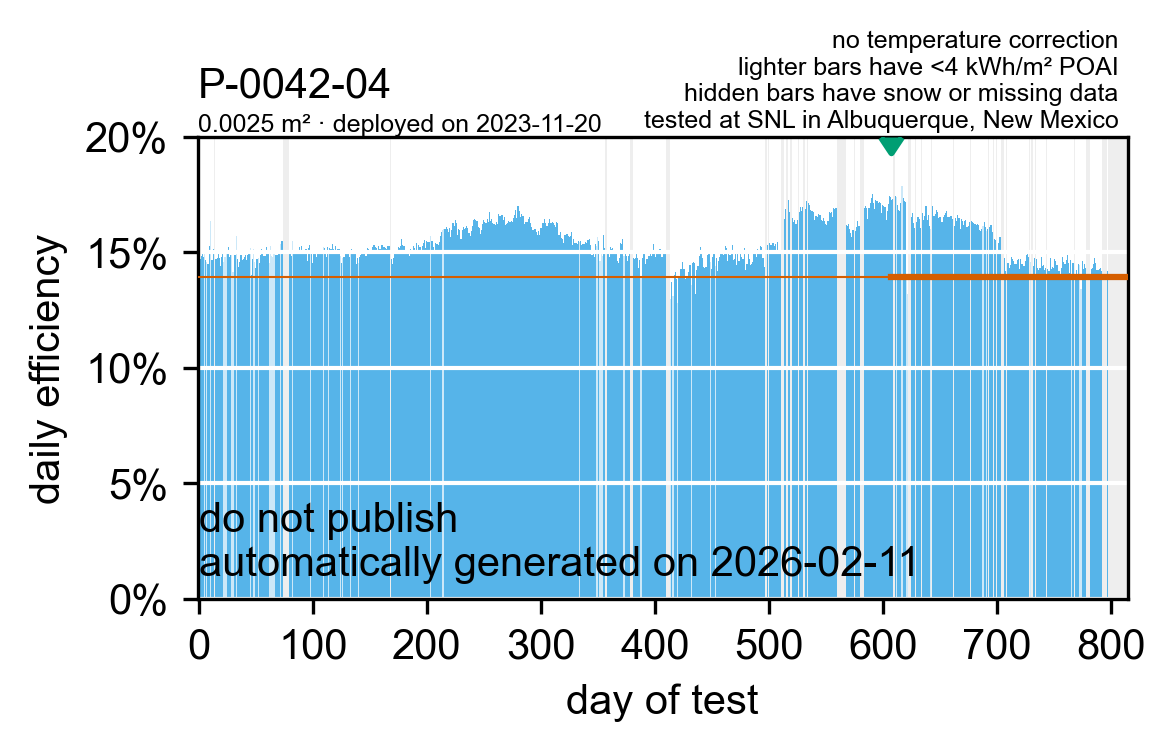

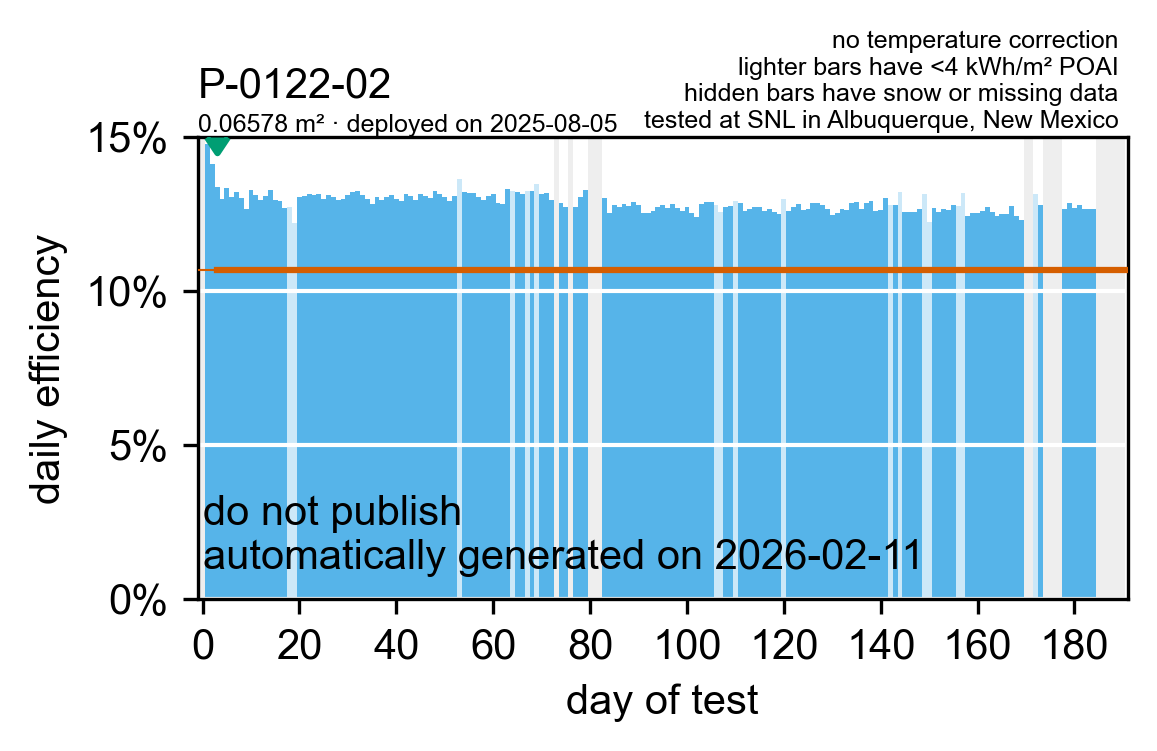

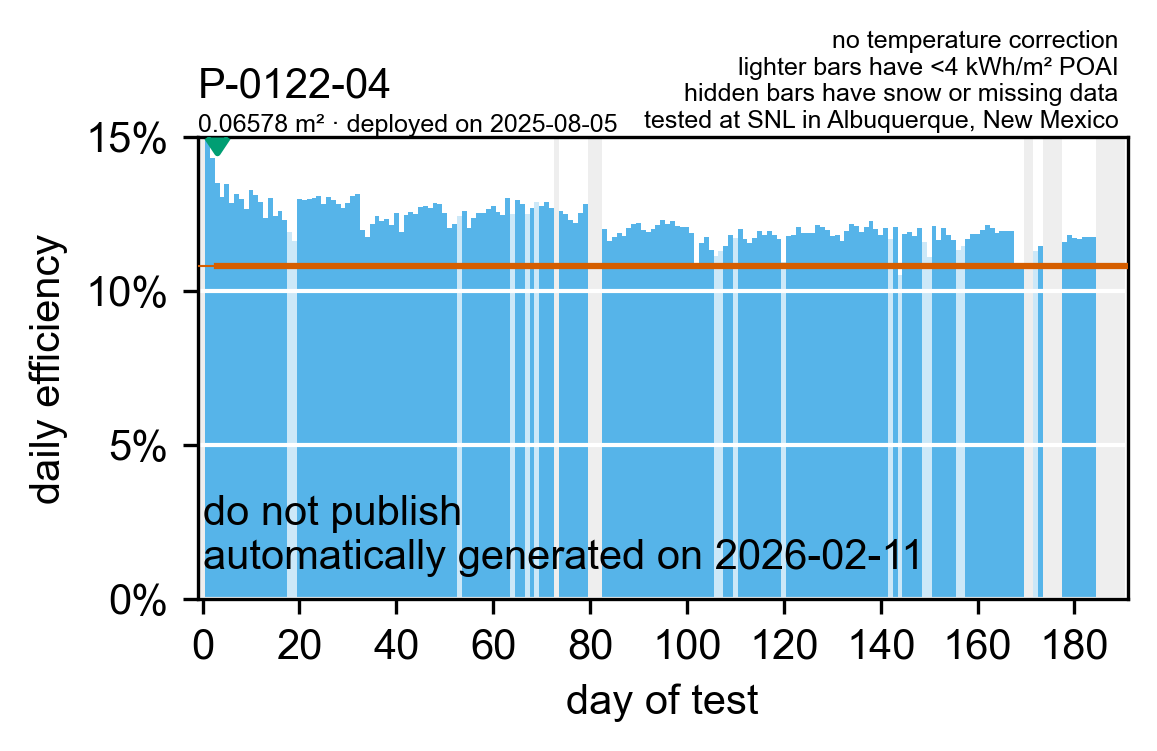

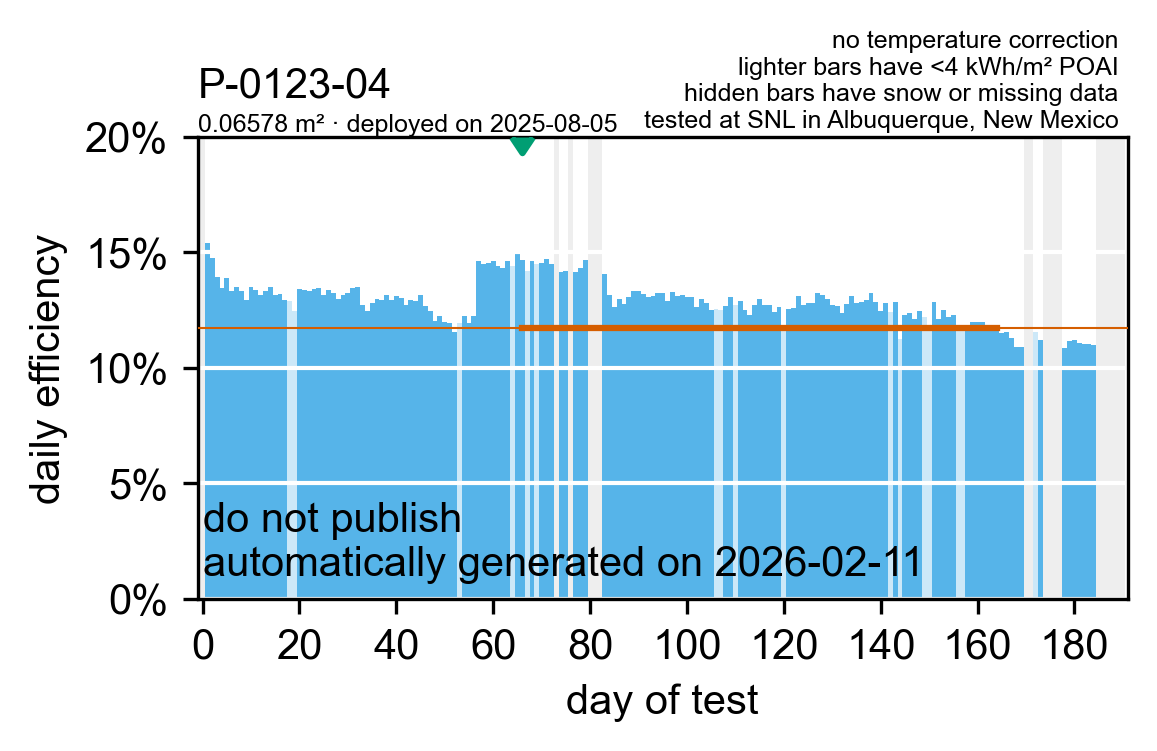

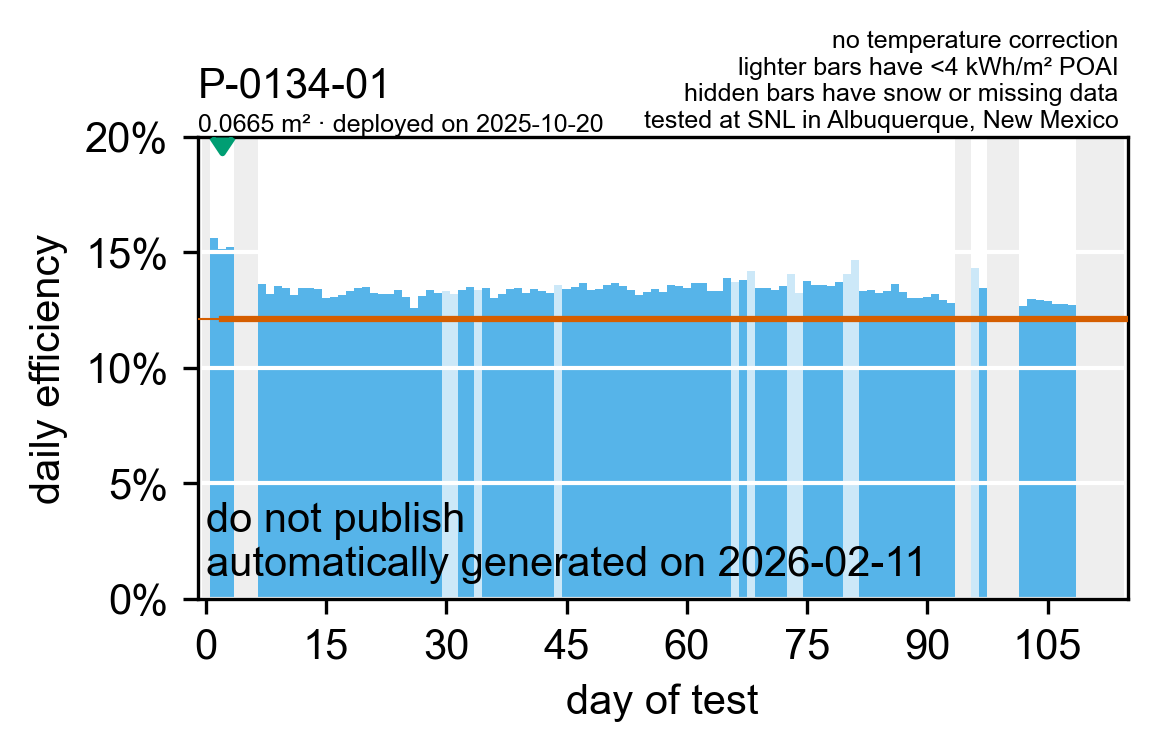

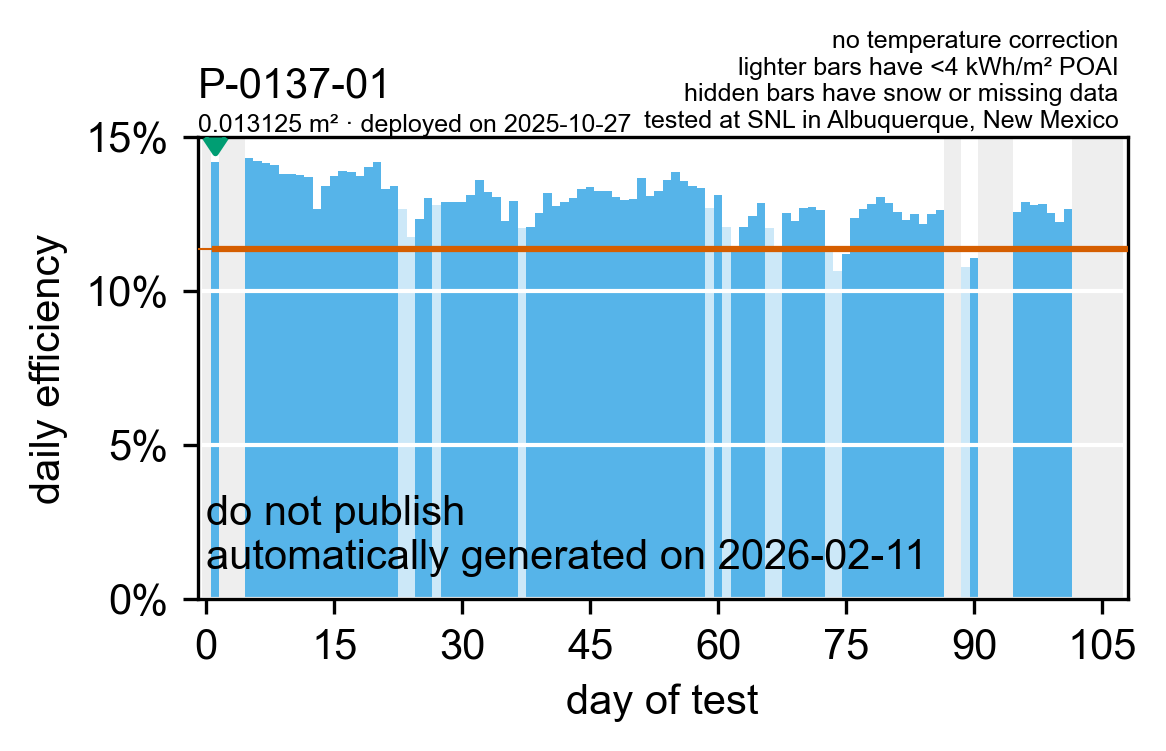

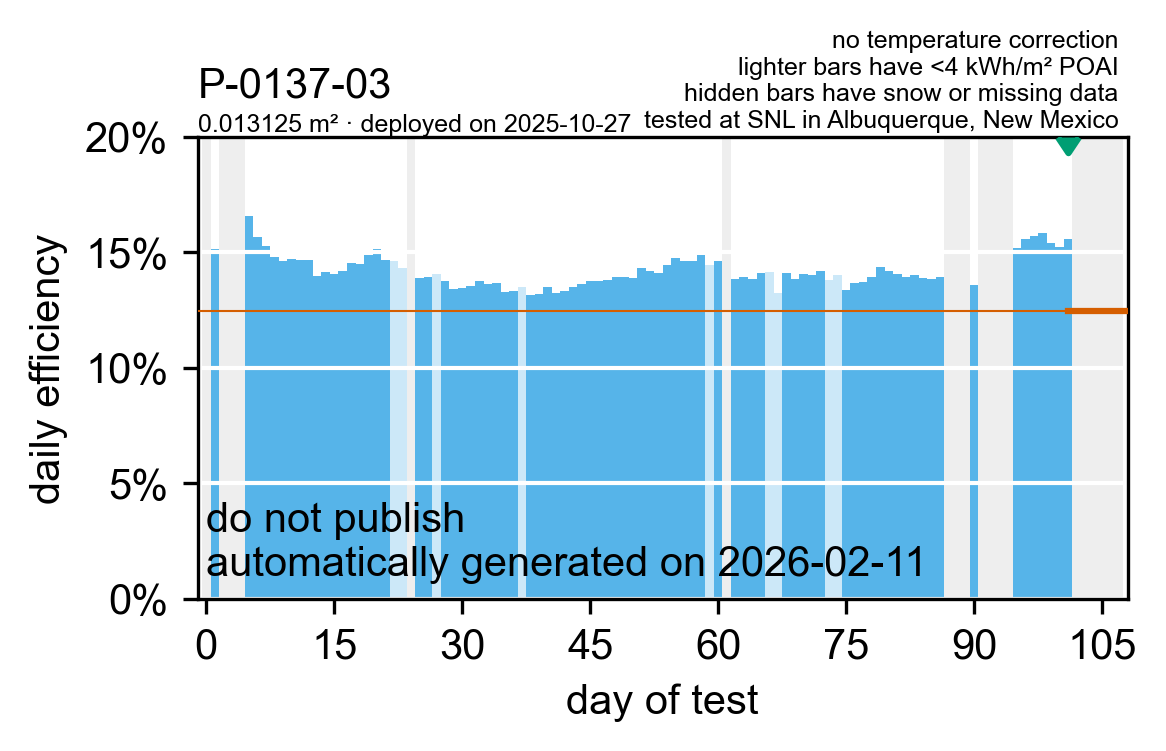

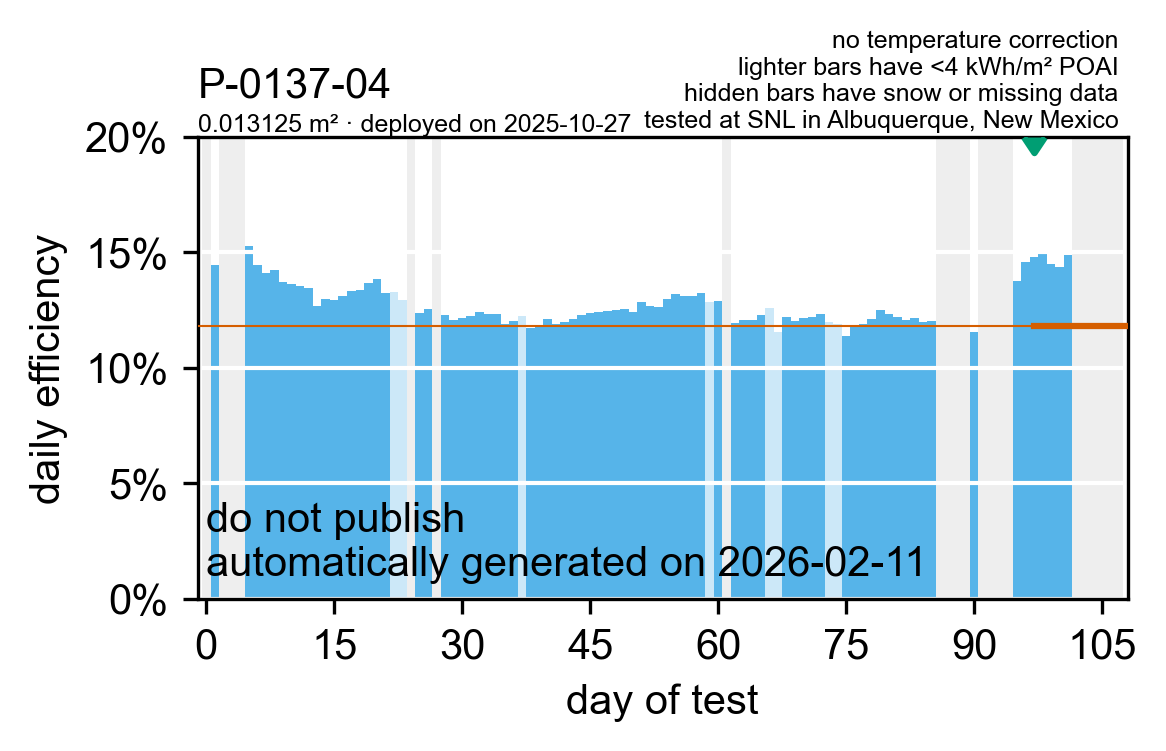

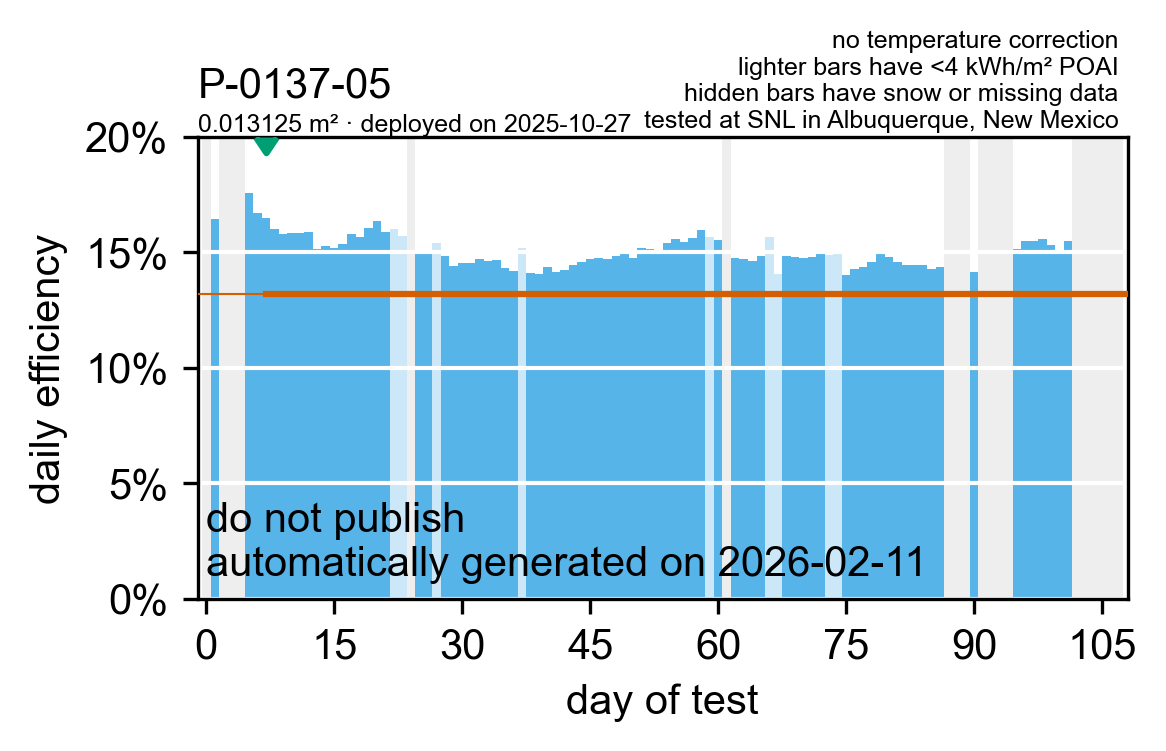

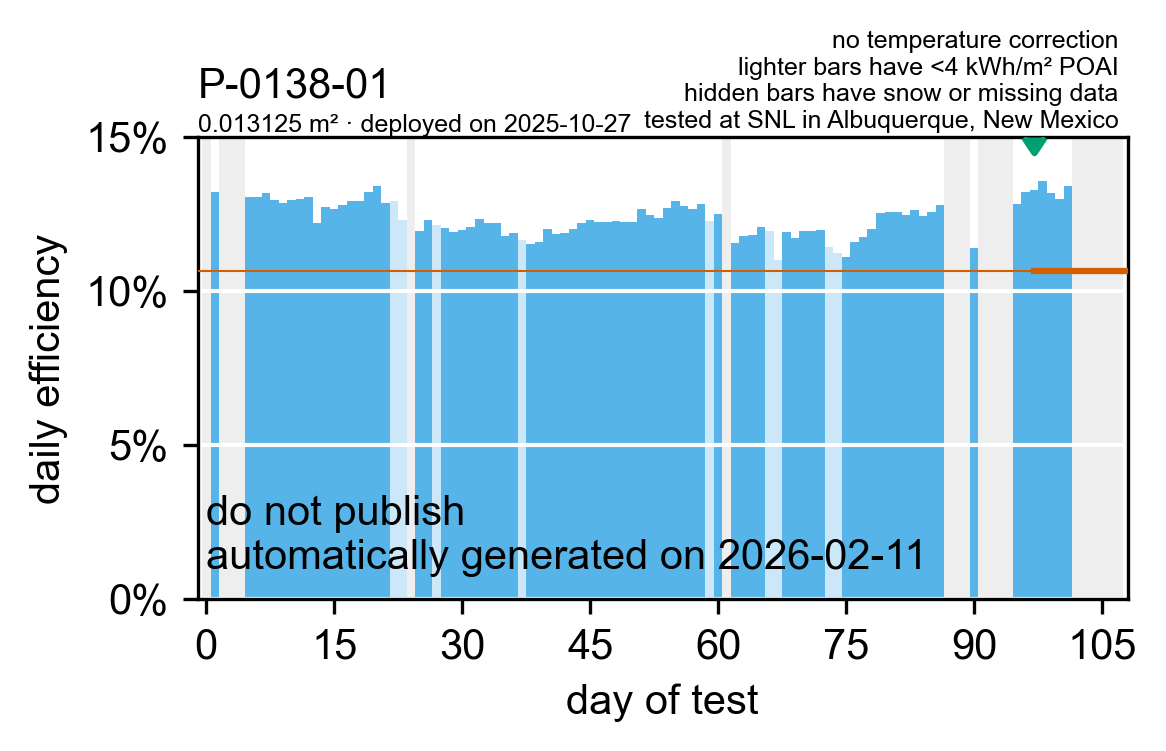

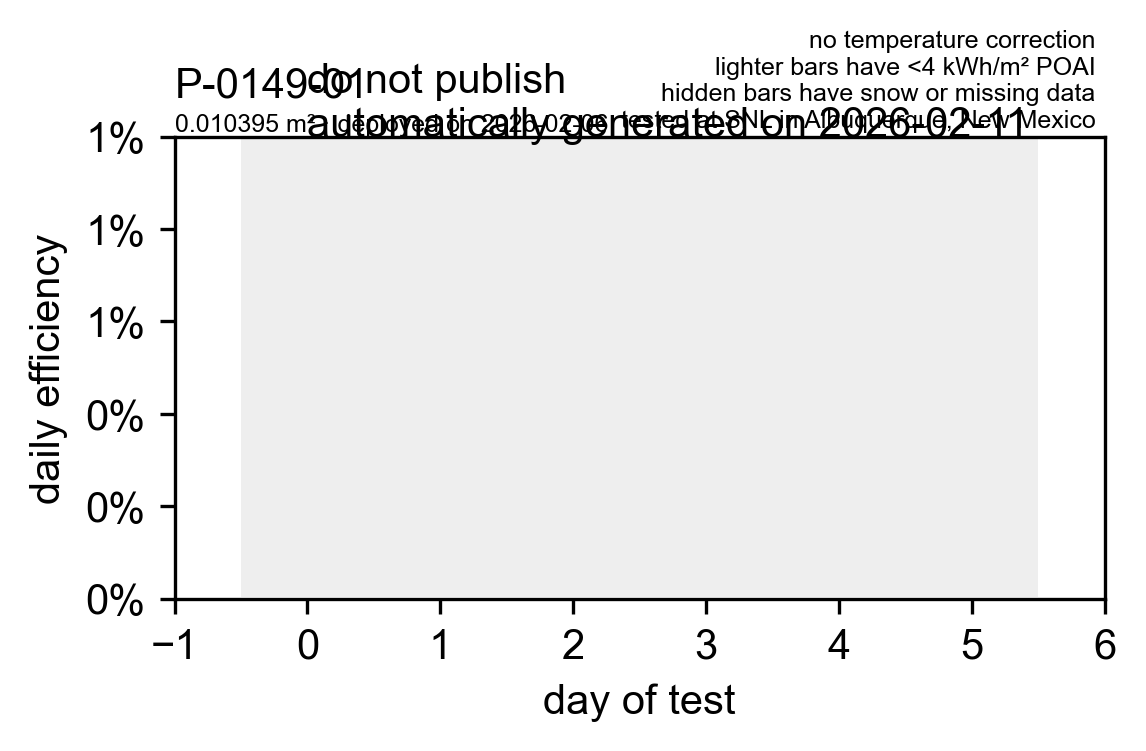

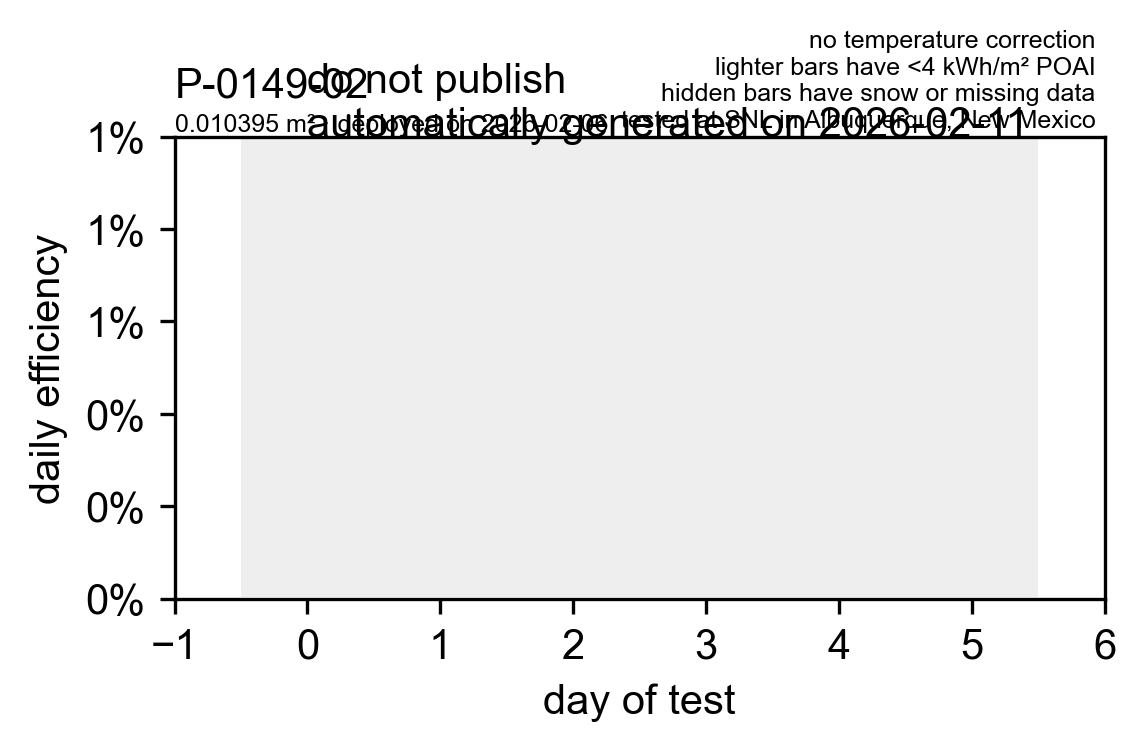

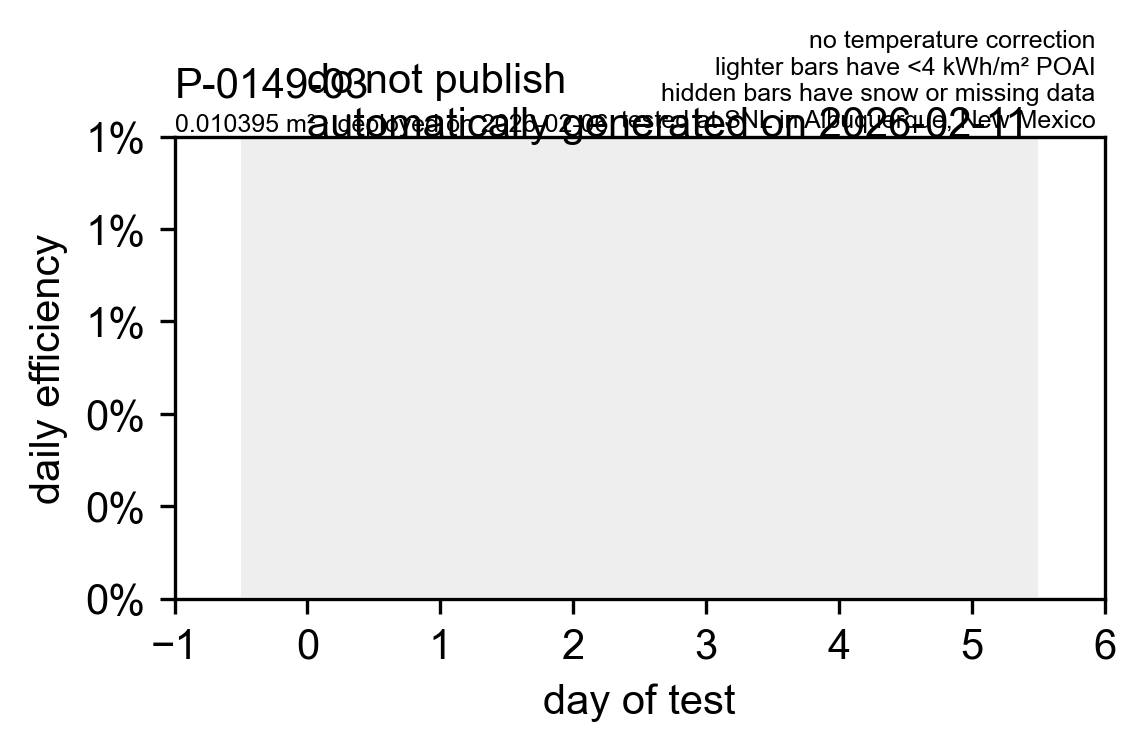

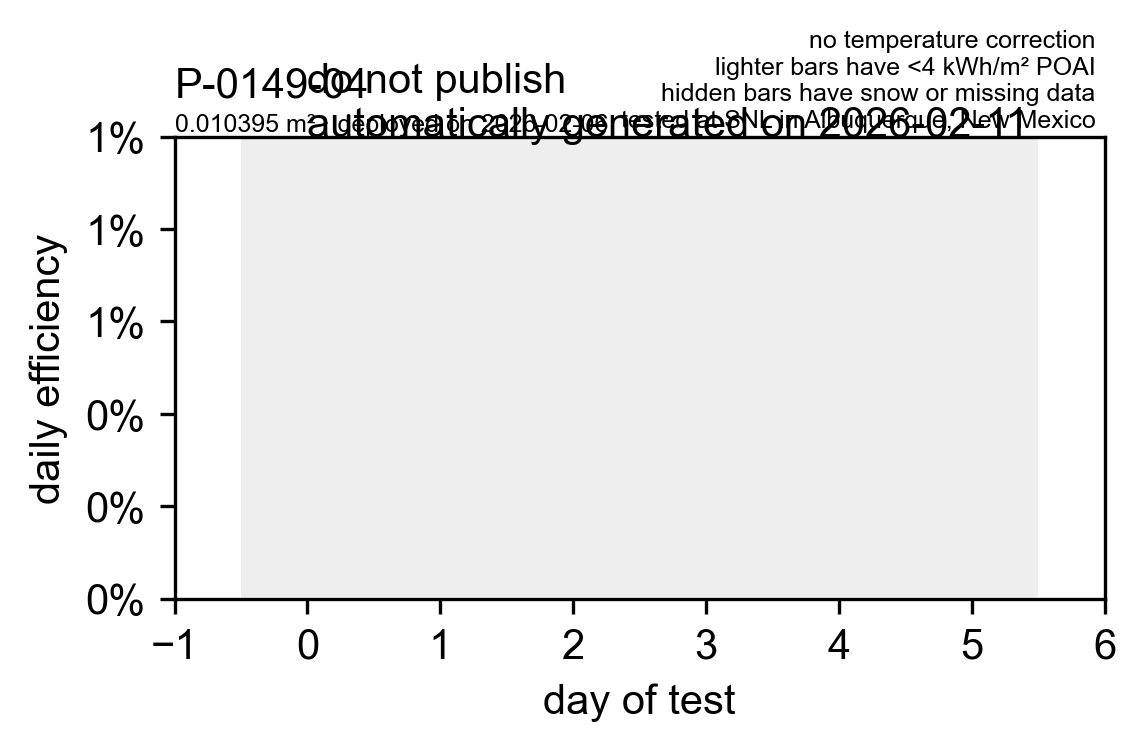

In [37]:
# Create a PowerPoint presentation object
presentation = Presentation()

for batch, info in batches2.items():
    modules = info['modules']
      
    for module in modules:
        #Make plots locally
        path = '/Users/jsstein/bin/Box Sync/PACT - Data/' + module[0:6] + '-XX/Outdoor_SNL/daily_plots/'
        fig = pp.daily_performance_plot(module)
        #axes = fig.get_axes()
        #ax = axes[0]
        #ax.set_xlim(0,54)
        plt.text(0,0.01,'do not publish\nautomatically generated on ' + datetime.today().strftime('%Y-%m-%d'))
        fig.savefig(path + 'daily_efficiency_' + module + '.png', bbox_inches='tight')
        #plt.close()
        
        # Create a new slide in the presentation
        slide = presentation.slides.add_slide(presentation.slide_layouts[5])  # Using a blank slide layout
        # Add the plot image to the slide
        left = Inches(1)
        top = Inches(1)
        height = Inches(4.5)
        slide.shapes.add_picture(path + 'daily_efficiency_' + module + '.png', left, top, height=height)
         # Remove the title box if it exists
        for shape in slide.shapes:
            if shape.has_text_frame and shape.text_frame.text == "":
                sp = shape
                slide.shapes._spTree.remove(sp._element)
        
        # #Write file to BOX (comment out this section to stop the writing to BOX
        # client = make_client()
        # folders = get_key_folders(module[0:6], client)
        # datafile = path + 'daily_efficiency_' + module + '.png'
        # upload_file(datafile, folders['daily_plots'], client)
        # print('Uploaded ' + 'daily_efficiency_' + module + '.png' + ' to BOX')

        #Write file to AWS S3
        s3_key = module[:6] + '-XX/Outdoor_SNL/daily_plots/' + 'daily_efficiency_' + module + '.png'
        bucket.upload_file(path + 'daily_efficiency_' + module + '.png' ,s3_key)
        print(s3_key + ' copied to AWS S3')
    
    # Save the PowerPoint presentation
    presentation.save('Sandia_PACT_Plots.pptx')

In [ ]:
tablename = 'dbo.PACT_MPPTData'
start_date = '2025-11-01'
end_date = '2025-11-17'
sql = f"SELECT * FROM {tablename} WHERE TmStamp BETWEEN '{start_date}' AND '{end_date}' ORDER BY TmStamp ASC"
df = pd.read_sql(sql, engine, index_col="TmStamp")
df.index = df.index.tz_localize('MST')
df.drop(columns=['PACTMPPTDataID', 'Power', 'Filename'], inplace=True)
df = df.rename(columns={'Voltage': 'vmp', 'Current': 'imp', 'Temperature':'temperature_module'})
df = df.rename_axis('date_time')
#df = df.loc[df['ModuleID']==pact_id,:]

In [ ]:
dfmod = df[df['ModuleID']=='P-0121-01']
power = dfmod['vmp']*dfmod['imp']
power.plot()

In [ ]:
tablename = 'dbo.PACT_MET_PACTTracker2'
sql = f"SELECT TmStamp, E_Tracker2_Wm2_Avg, Trkr2Azimuth, Trkr2Altitude FROM {tablename} WHERE TmStamp BETWEEN '{start_date}' AND '{end_date}' ORDER BY TmStamp ASC"
df_tracker2 = pd.read_sql(sql, engine, index_col="TmStamp")
df_tracker2 = df_tracker2.rename(columns={'E_Tracker2_Wm2_Avg': 'poa_global', 'Trkr2Azimuth': 'surface_azimuth', 'Trkr2Altitude':'surface_tilt'})
df_tracker2 = df_tracker2.rename_axis('date_time')
df_tracker2.index = df_tracker2.index.tz_localize('MST')
df_tracker2['poa_global'].plot()